In [7]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# 1. 데이터 불러오기
try:
    train_df = pd.read_csv('../data/train.csv')
    test_df = pd.read_csv('../data/test.csv')
    submission_df = pd.read_csv('../data/sample_submission.csv')
except FileNotFoundError:
    print("파일 경로를 다시 확인해주세요.")
    exit()

# 2. 전처리 및 파생 변수 생성 함수
def preprocess_and_feature_engineer(df):
    df_processed = df.copy()
    
    if 'gender' in df_processed.columns:
        df_processed = df_processed.drop('gender', axis=1)

    df_processed.loc[df_processed['bone_density'] < 0, 'bone_density'] = 0
    df_processed[['medical_history', 'family_medical_history', 'edu_level']] = df_processed[['medical_history', 'family_medical_history', 'edu_level']].fillna('unknown')
    df_processed['mean_working'] = df_processed.groupby(['smoke_status', 'edu_level'])['mean_working'].transform(lambda x: x.fillna(x.median()))
    df_processed['mean_working'] = df_processed['mean_working'].fillna(df_processed['mean_working'].median())
    
    categorical_cols = ['activity', 'smoke_status', 'sleep_pattern',
                        'medical_history', 'family_medical_history', 'edu_level']
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
    
    df_processed['BMI'] = df_processed['weight'] / (df_processed['height'] / 100) ** 2
    df_processed['Pulse_Pressure'] = df_processed['systolic_blood_pressure'] - df_processed['diastolic_blood_pressure']
    df_processed['bp_interaction'] = df_processed['systolic_blood_pressure'] * df_processed['diastolic_blood_pressure']
    df_processed['cholesterol_glucose_ratio'] = df_processed['cholesterol'] / (df_processed['glucose'] + 1)
    
    return df_processed

# 3. 데이터에 함수 적용
train_final = preprocess_and_feature_engineer(train_df.copy())
test_final = preprocess_and_feature_engineer(test_df.copy())

# 4. 학습 데이터와 테스트 데이터의 컬럼 일치시키기
train_cols = set(train_final.columns)
test_cols = set(test_final.columns)
common_cols = list(train_cols.intersection(test_cols))
common_cols = [col for col in common_cols if col not in ['ID', 'stress_score']]

# 🌟🌟🌟 중요도가 낮다고 판단되어 제거할 변수 리스트 🌟🌟🌟
# 기존 베이스라인 변수들에 'family_medical_history_unknown' 추가
low_importance_features = [
    'sleep_pattern_sleep difficulty',
    'activity_moderate',
    'mean_working',
    'family_medical_history_unknown' # 이번에 추가된 변수
]
final_cols = [col for col in common_cols if col not in low_importance_features]

# 5. K-Fold 교차 검증을 통한 RMSE 측정
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lgb_oof = np.zeros(len(train_final))
xgb_oof = np.zeros(len(train_final))

X_train_full = train_final[final_cols]
y_train_full = train_final['stress_score']

print("--- 로컬 점수 측정 시작 ---")
for fold, (train_index, val_index) in enumerate(kf.split(X_train_full, y_train_full)):
    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

    lgb_model = lgb.LGBMRegressor(
        random_state=42, n_estimators=300, learning_rate=0.1, num_leaves=40
    )
    lgb_model.fit(X_train, y_train)
    lgb_oof[val_index] = lgb_model.predict(X_val)

    xgb_model = xgb.XGBRegressor(
        random_state=42, n_estimators=500, learning_rate=0.1, max_depth=7, n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    xgb_oof[val_index] = xgb_model.predict(X_val)

weight_lgb = 0.6
weight_xgb = 0.4
oof_predictions = (weight_lgb * lgb_oof) + (weight_xgb * xgb_oof)
oof_rmse = np.sqrt(mean_squared_error(y_train_full, oof_predictions))

print(f"**교차 검증 RMSE 예상 점수**: {oof_rmse:.5f}")
print("---")

# 6. 최종 모델 학습 및 제출 파일 생성
print("--- 최종 모델 학습 및 제출 파일 생성 시작 ---")

final_lgb_model = lgb.LGBMRegressor(
    random_state=42, n_estimators=300, learning_rate=0.1, num_leaves=40
)
final_lgb_model.fit(X_train_full, y_train_full)

final_xgb_model = xgb.XGBRegressor(
    random_state=42, n_estimators=500, learning_rate=0.1, max_depth=7, n_jobs=-1
)
final_xgb_model.fit(X_train_full, y_train_full)

# 테스트 데이터에 대한 예측
lgb_test_preds = final_lgb_model.predict(test_final[final_cols])
xgb_test_preds = final_xgb_model.predict(test_final[final_cols])

# 예측값 앙상블
final_predictions = (weight_lgb * lgb_test_preds) + (weight_xgb * xgb_test_preds)

# 제출 파일 생성
submission_df['stress_score'] = final_predictions
submission_df.to_csv('submission.csv', index=False)

print("✅ submission.csv 파일 생성 완료!")
print("\n테스트 데이터 예측값 (상위 5개):\n", final_predictions[:5])

--- 로컬 점수 측정 시작 ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2281
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 24
[LightGBM] [Info] Start training from score 0.481912


c:\Users\rladud\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\rladud\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\rladud\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\rladud\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2282
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 24
[LightGBM] [Info] Start training from score 0.486092
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2280
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 24
[LightGBM] [Info] Start training from score 0.481937
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [In

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 24
[LightGBM] [Info] Start training from score 0.482130


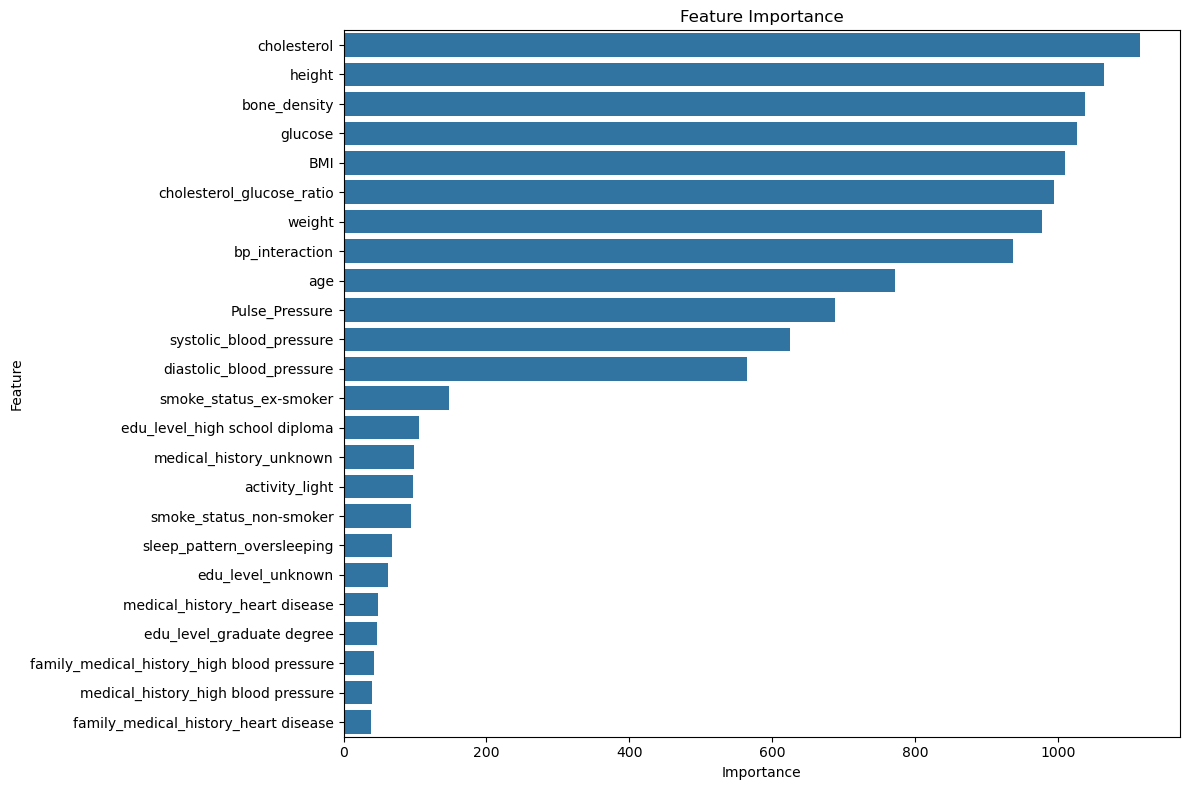

✅ 변수 중요도 시각화 완료! 어떤 변수들이 중요한지 확인해봐.


In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
try:
    train_df = pd.read_csv('../data/train.csv')
    test_df = pd.read_csv('../data/test.csv')
    submission_df = pd.read_csv('../data/sample_submission.csv')
except FileNotFoundError:
    print("파일 경로를 다시 확인해주세요.")
    exit()

# 전처리 및 파생 변수 생성 함수 (최고점 코드와 동일)
def preprocess_and_feature_engineer(df):
    df_processed = df.copy()
    
    if 'gender' in df_processed.columns:
        df_processed = df_processed.drop('gender', axis=1)

    df_processed.loc[df_processed['bone_density'] < 0, 'bone_density'] = 0
    df_processed[['medical_history', 'family_medical_history', 'edu_level']] = df_processed[['medical_history', 'family_medical_history', 'edu_level']].fillna('unknown')
    df_processed['mean_working'] = df_processed.groupby(['smoke_status', 'edu_level'])['mean_working'].transform(lambda x: x.fillna(x.median()))
    df_processed['mean_working'] = df_processed['mean_working'].fillna(df_processed['mean_working'].median())
    
    categorical_cols = ['activity', 'smoke_status', 'sleep_pattern',
                        'medical_history', 'family_medical_history', 'edu_level']
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
    
    df_processed['BMI'] = df_processed['weight'] / (df_processed['height'] / 100) ** 2
    df_processed['Pulse_Pressure'] = df_processed['systolic_blood_pressure'] - df_processed['diastolic_blood_pressure']
    df_processed['bp_interaction'] = df_processed['systolic_blood_pressure'] * df_processed['diastolic_blood_pressure']
    df_processed['cholesterol_glucose_ratio'] = df_processed['cholesterol'] / (df_processed['glucose'] + 1)
    
    return df_processed

# 데이터에 함수 적용
train_final = preprocess_and_feature_engineer(train_df.copy())

# 중요도가 낮다고 판단되어 제거할 변수 리스트 (최고점 모델)
low_importance_features = [
    'sleep_pattern_sleep difficulty',
    'activity_moderate',
    'mean_working',
    'family_medical_history_unknown'
]
final_cols = [col for col in train_final.columns if col not in low_importance_features and col not in ['ID', 'stress_score']]

X_train_full = train_final[final_cols]
y_train_full = train_final['stress_score']

# LightGBM 모델 학습
lgb_model = lgb.LGBMRegressor(random_state=42, n_estimators=300, learning_rate=0.1, num_leaves=40)
lgb_model.fit(X_train_full, y_train_full)

# 변수 중요도 추출 및 시각화
feature_importances = pd.DataFrame({
    'Feature': X_train_full.columns,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

print("✅ 변수 중요도 시각화 완료! 어떤 변수들이 중요한지 확인해봐.")